In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import re
import pandas as pd
import matplotlib.pylab as plt

In [3]:
from image_analysis.read_files import *
from image_analysis.fit import plot, statistics
from image_analysis.fit import regionprops
from image_analysis.preprocess import mask

In [4]:
df_system_size = pd.read_excel("system_size_L_and_gaps_x0/system_size_L_and_gaps_x0.xlsx")
df_volumes     = pd.read_excel("volumes/volumes.xlsx")


df             = pd.merge( df_system_size, df_volumes, on='pretreated_file_name', how='inner', suffixes=('_x', '_y'))

for col in df.columns:
    if col.endswith('_x'):
        base_col = col[:-2]  # Get the base column name (without suffix)
        if f"{base_col}_y" in df.columns:
            # Combine the two columns, prioritizing non-NaN values
            df[base_col] = df[[f"{base_col}_x", f"{base_col}_y"]].bfill(axis=1)[f"{base_col}_x"]
            # Drop the original suffixed columns
            df.drop(columns=[f"{base_col}_x", f"{base_col}_y"], inplace=True)

# Plot 

In [5]:
from matplotlib_defaults import *

# smaller fonts
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10

# Set axis ticks
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

In [6]:
colormap = plt.colormaps['Dark2']
colors = colormap(np.linspace(0, 1, 10))
sizes = [1.5, 2.5, 5, 7]
size_to_color = {
    1.5: colors[1], 
    2.5: colors[2],
    5.0: colors[3],
    7.0: colors[4]
}

df['color'] = df['animal_size'].map(size_to_color)

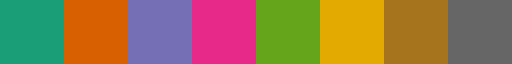

In [7]:
colormap

In [8]:
df.head()

,pretreated_file_name,system_size_L_along_SF_pc40_um,length_L_SF_pc40_um,x0_pc40_um_shh,x0_pc40_um_fgf,system_size_L_along_SF_pc50_um,length_L_SF_pc50_um,x0_pc50_um_shh,x0_pc50_um_fgf,system_size_L_along_SF_pc60_um,...,volume_80pc_8um_shh,volume_80pc_8um_fgf,volume_80pc_8um_dusp,hcr,animal_size,time,shh_segm,fgf_segm,dusp_segm,color
0,hcr11_lb27_fl,288,172,42,72,288,178,40,68,288,...,3082,12253,16087.0,11,1.5,1,yes,yes,yes,"[0.10588235294117647, 0.6196078431372549, 0.46..."
1,hcr11_lb28_fl,298,162,52,82,304,162,56,84,308,...,2572,45073,5176.0,11,1.5,1,yes,yes,yes,"[0.10588235294117647, 0.6196078431372549, 0.46..."
2,hcr11_lb28_fr,264,52,112,60,174,88,30,54,170,...,1301,8933,4636.0,11,1.5,1,yes,yes,yes,"[0.10588235294117647, 0.6196078431372549, 0.46..."
3,hcr15_lb41_fl,314,154,36,122,256,160,32,62,280,...,5607,16370,58033.0,15,1.5,1,yes,yes,yes,"[0.10588235294117647, 0.6196078431372549, 0.46..."
4,hcr16_lb44_fl,238,114,50,72,246,128,50,66,258,...,5183,45063,28987.0,16,1.5,1,yes,yes,yes,"[0.10588235294117647, 0.6196078431372549, 0.46..."


# Remove another method for Dusp

In [9]:
df.loc[df['hcr'] == 23, df.columns[df.columns.str.contains('dusp')]] = pd.NA

# Dynamic ~ L_blastema vs. static ~ L_animal_size scaling

In [10]:
pc = 50

df.sort_values(by=[f'system_size_L_along_SF_pc{pc}_um'], inplace=True)

for i, volume_col in enumerate([f'volume_{pc}pc_8um_shh', f'volume_{pc}pc_8um_fgf', f'volume_{pc}pc_8um_dusp']): 
    df[f'length_{pc}pc_um_{volume_col.split("_")[-1]}'] = (8 * df[volume_col]) ** (1/3)

df[f'length_{pc}pc_um_diff_dusp_fgf'] =  df[f'length_{pc}pc_um_dusp'] - df[f'length_{pc}pc_um_fgf']

In [11]:
columns_to_plot = [
    #f'length_L_SF_pc{pc}_um',
    f'length_{pc}pc_um_shh', 
    f'length_{pc}pc_um_fgf', 
    f'x0_pc{pc}_um_shh', 
    f'x0_pc{pc}_um_fgf', 
    f'length_{pc}pc_um_dusp', 
    #f'length_{pc}pc_um_diff_dusp_fgf'
]

mean length_50pc_um_shh / (blastema size) = 0.18690574693946685
mean length_50pc_um_fgf / (blastema size) = 0.27701339038721073
mean x0_pc50_um_shh / (blastema size) = 0.20101230201586598
mean x0_pc50_um_fgf / (blastema size) = 0.29680827483427863
mean length_50pc_um_dusp / (blastema size) = 0.39324813781637896


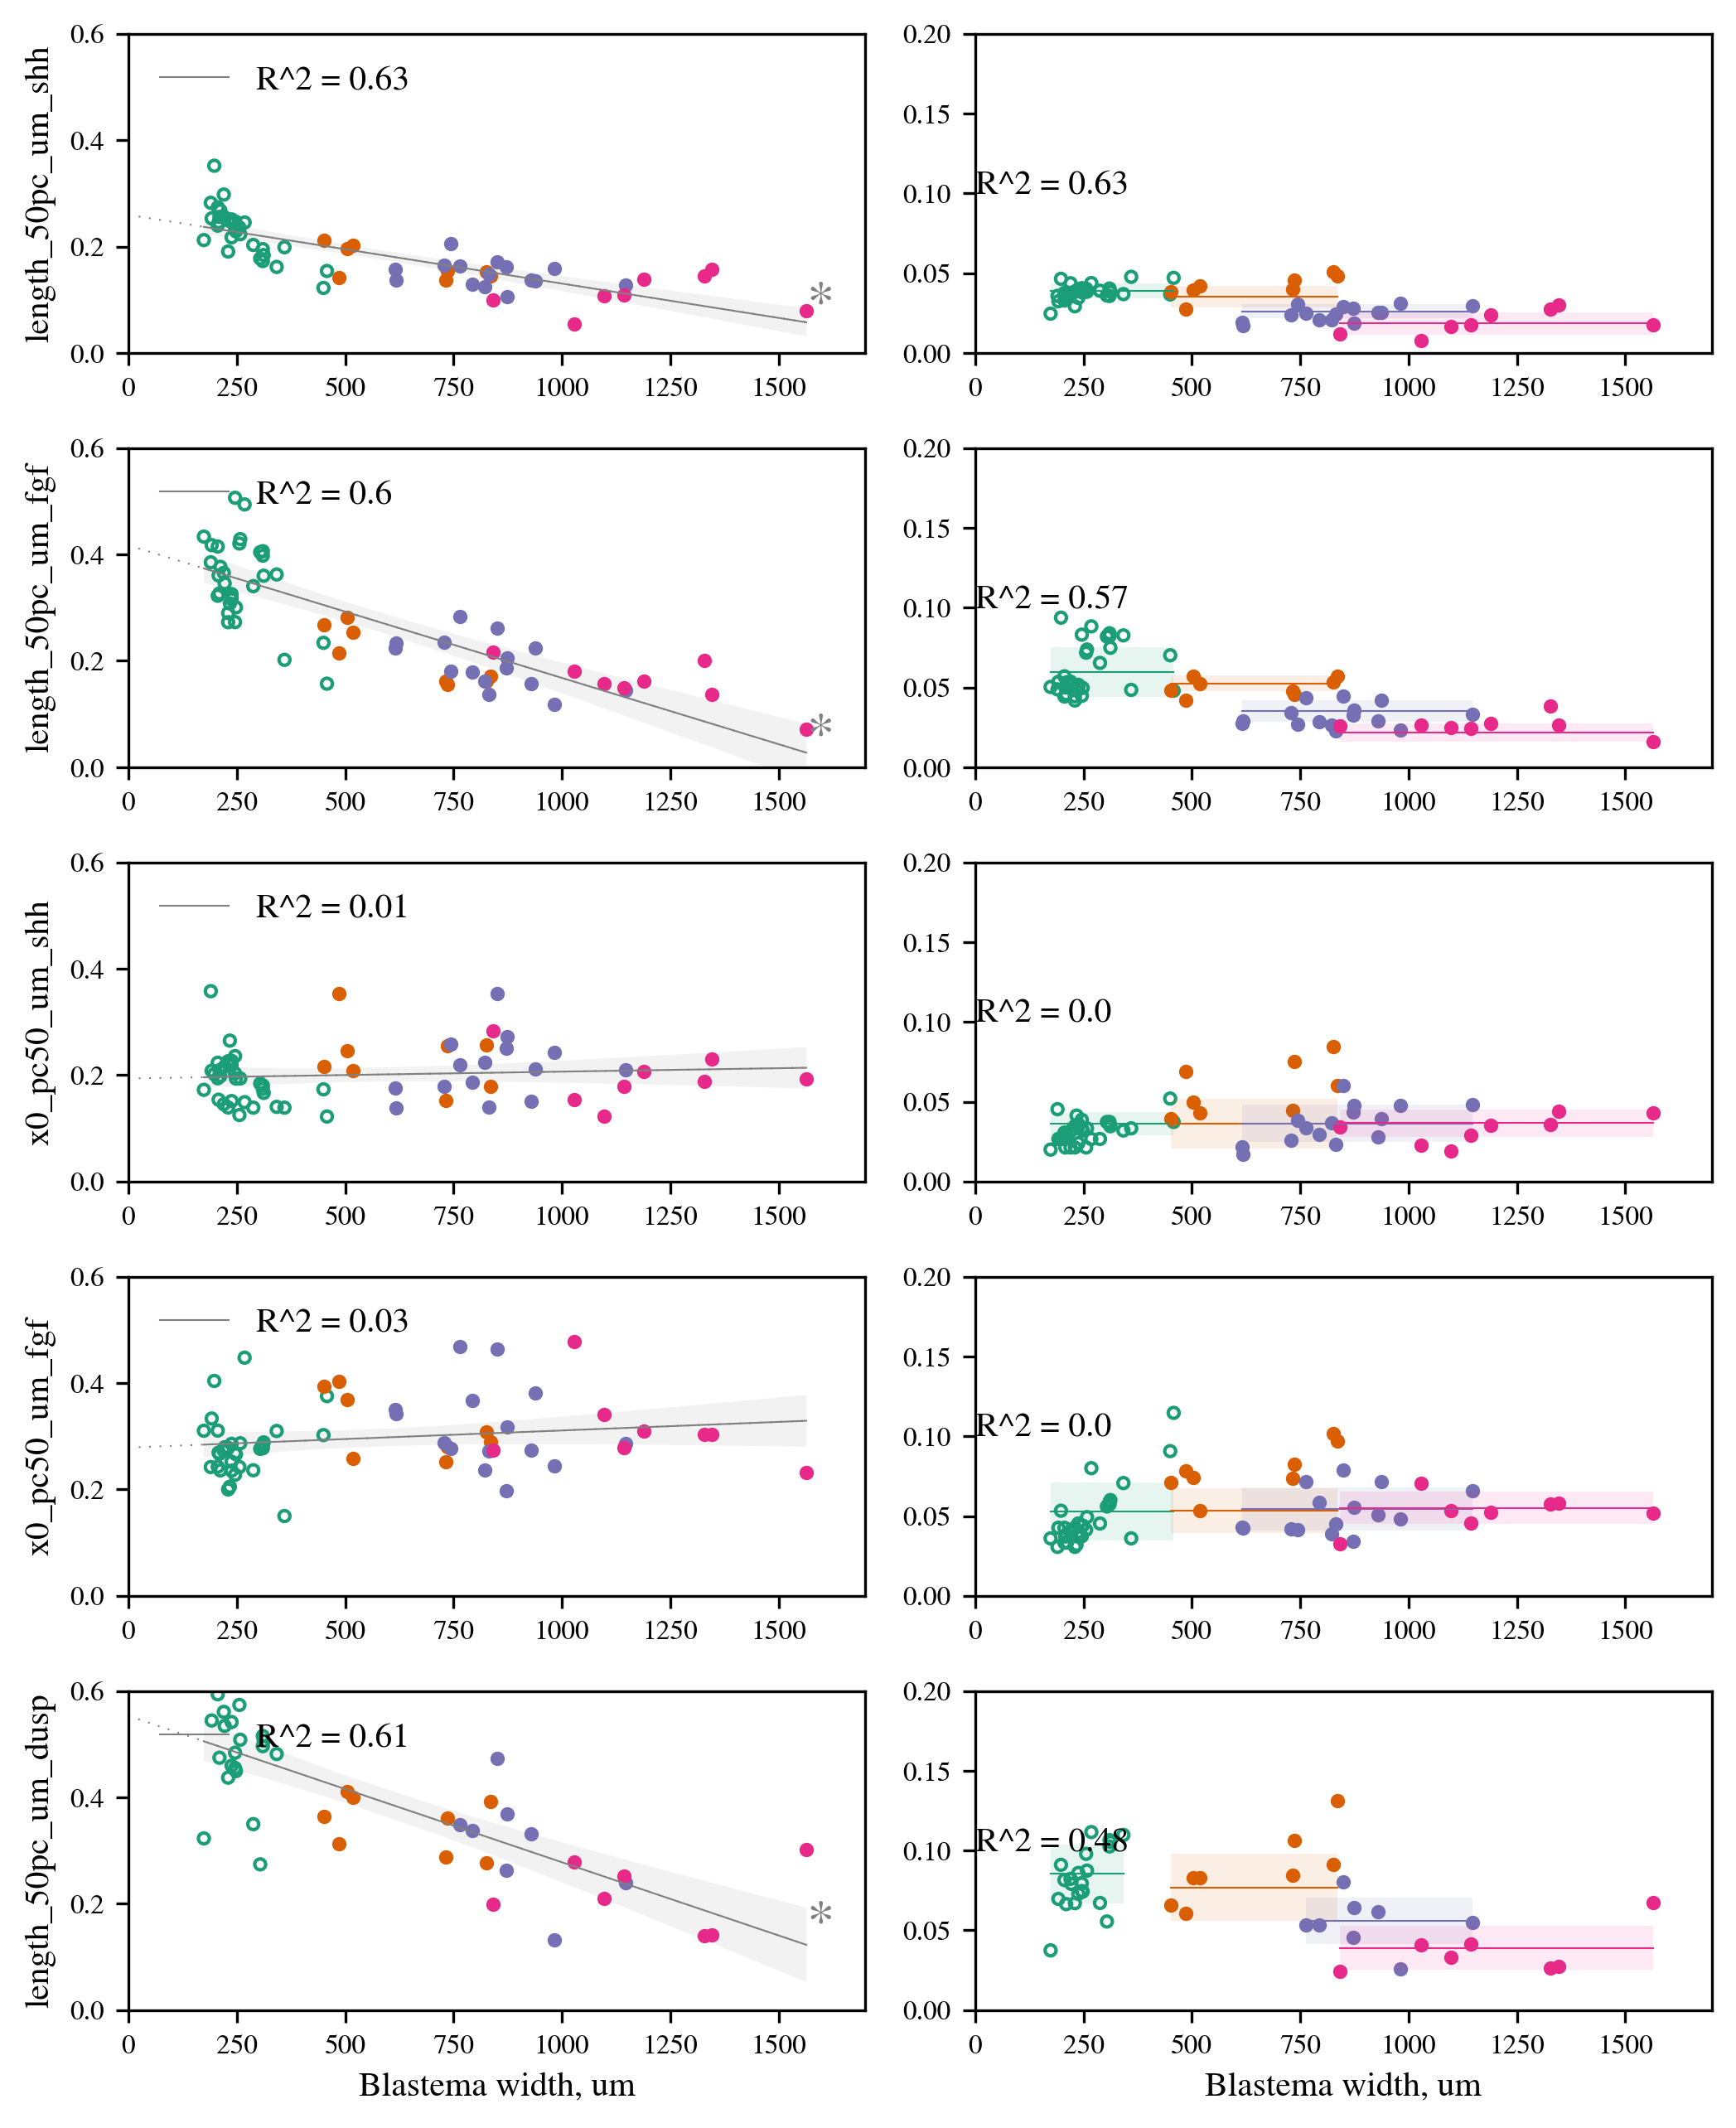

In [12]:
nrows, ncols = len(columns_to_plot), 2
fig, ax = plt.subplots(nrows, ncols, figsize=(default_figsize["large"][0], default_figsize["large"][1]), sharex=False, sharey=False)

df.sort_values(by=[f'system_size_L_along_SF_pc{pc}_um'], inplace=True)

for i, to_plot in enumerate( columns_to_plot ): 
    for j in [0, 1]:
        ######### 1st column #########
        if j == 0: 
            x = np.array(df[f'system_size_L_along_SF_pc{pc}_um'])
            y = np.array(df[to_plot]) # um

            # regression through all
            x, y = x[~np.isnan(y)], y[~np.isnan(y)]
            x, y = x[~np.isnan(x)], y[~np.isnan(x)]

            y = y / x

            print(f'mean {to_plot} / (blastema size) = {np.mean(y)}')
            
            _, _, _, r2 = plot.add_regr(ax[i, j], x, y, 'gray', '', fit_intercept=True, extend_to_zero=True)

            for size in [1.5, 2.5,5, 7]:
                df_regr = df[df['animal_size'] == size]
                    
                x = np.array(df_regr[f'system_size_L_along_SF_pc{pc}_um'])
                y = np.array(df_regr[to_plot]) # um

                y = y / x
                
                if size != 1.5:
                    ax[i, j].scatter(
                        x, y,
                        edgecolor=size_to_color[size], facecolor=size_to_color[size],
                        s=10
                    )
                else: # plot limb buds as empty dots
                    ax[i, j].scatter(
                        x, y,
                        edgecolor=size_to_color[size], facecolor='none',
                        s=10
                    )

                ax[i, j].set_ylabel( to_plot )
                ax[i, j].legend()
                ax[i, j].set_ylim(0, 0.6) 
                ax[i, j].set_xlim(0, 1700)
                
        ######### 2nd column #########
        else:

            x = np.array(df['animal_size'])
            y = np.array(df[to_plot]) # um
                
            x, y = x[~np.isnan(y)], y[~np.isnan(y)]
            x, y = x[~np.isnan(x)], y[~np.isnan(x)]

            y = y / (x * 1e3)

            # regression y = k * L_animal_size + b                    
            k, b, y_est, y_err, k_err, b_err, r2 = statistics.regr(x, y, fit_intercept=True, return_r2=True)

            ax[i, j].text(
                0.5, 0.1,
                f'R^2 = {round( r2, 2)}'
            )

            for size in [1.5, 2.5, 5, 7]:
                df_regr = df[df['animal_size'] == size]
            
                x = np.array(df_regr[f'system_size_L_along_SF_pc{pc}_um'])
                y = np.array(df_regr[to_plot]) # um
                    
                x, y = x[~np.isnan(y)], y[~np.isnan(y)]
                x, y = x[~np.isnan(x)], y[~np.isnan(x)]

                y = y / ( size * 1e3 )
                                      
                if size != 1.5:
                    ax[i, j].scatter(
                        x, y,
                        edgecolor=size_to_color[size], facecolor=size_to_color[size],
                        s=10,
                    )

                    C = k * size + b
                    y_est = np.zeros_like(x) + C
                    
                    std = (y - y_est).std()
                    y_err = np.zeros_like(x) + std
                    ax[i, j].fill_between(
                                    x, 
                                    y_est - y_err, 
                                    y_est + y_err, 
                                    facecolor = size_to_color[size],
                                    alpha=0.1
                                    )
                    ax[i, j].plot(x, y_est, color=size_to_color[size])
    
                else:
                    ax[i, j].scatter(
                        x, y,
                        edgecolor=size_to_color[size], facecolor='none',
                        s=10
                    )

                    C = k * size + b
                    y_est = np.zeros_like(x) + C
                    
                    std = (y - y_est).std()
                    y_err = np.zeros_like(x) + std
                    ax[i, j].fill_between(
                                    x, 
                                    y_est - y_err, 
                                    y_est + y_err, 
                                    facecolor = size_to_color[size],
                                    alpha=0.1
                                    )
                    ax[i, j].plot(x, y_est, color=size_to_color[size])
            
            ax[i, j].set_ylim(0, 0.2) 
            ax[i, j].set_xlim(0, 1700)

ax[4, 0].set_xlabel( 'Blastema width, um' )
ax[4, 1].set_xlabel( 'Blastema width, um' )
plt.tight_layout()
plt.savefig(f'final/figure_4_pc{pc}_Lbl_vs_Lanimal_ratio.pdf')
plt.show()